In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif

In [ ]:
data = pd.read_csv("../data/raw/train.csv").sort_values(by="id")

In [37]:
data.dtypes

id                             int64
Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

In [38]:
object_cols = data.select_dtypes(include='object').columns
data[object_cols] = data[object_cols].astype('category')

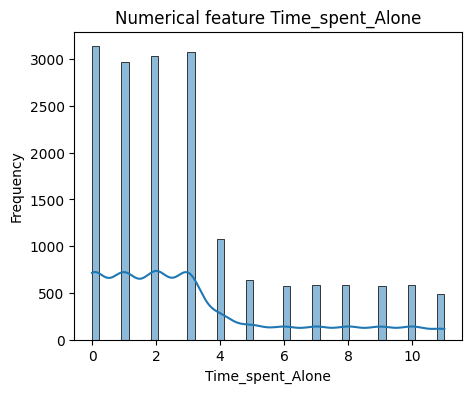

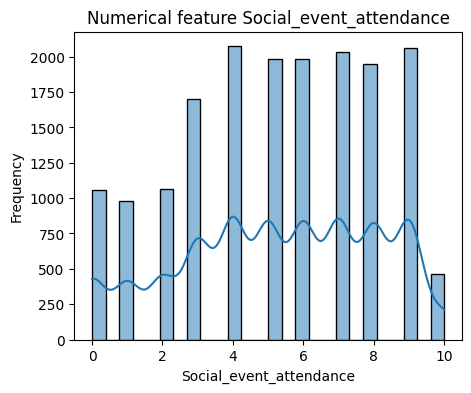

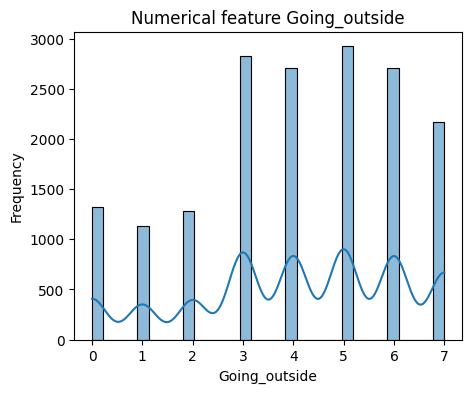

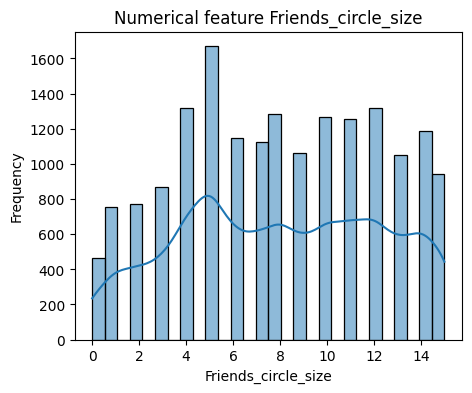

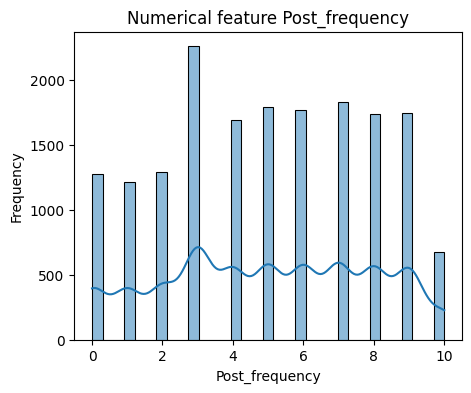

In [61]:
num_cols = data.drop(columns="id").select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(5, 4))
    sns.histplot(data[col].dropna(), kde=True)
    plt.title(f'Numerical feature {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

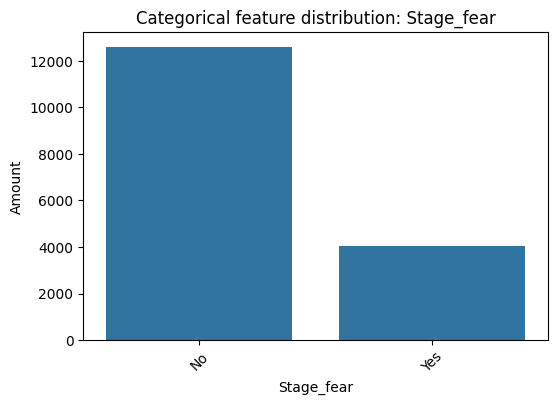

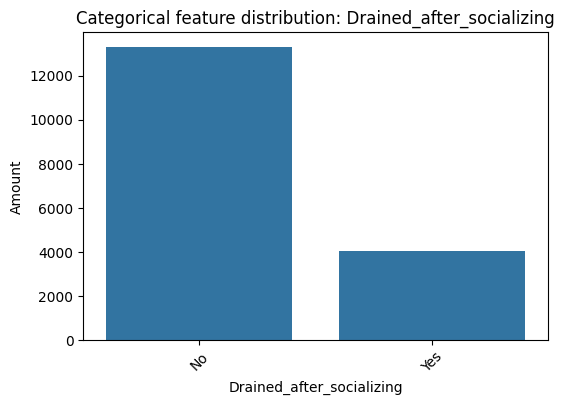

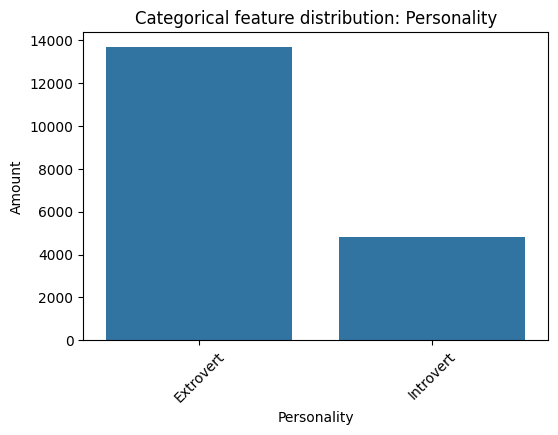

In [42]:
cat_cols = data.select_dtypes(include=['category']).columns

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x=col, order=data[col].value_counts().index[:10])
    plt.title(f'Categorical feature distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Amount')
    plt.xticks(rotation=45)
    plt.show()

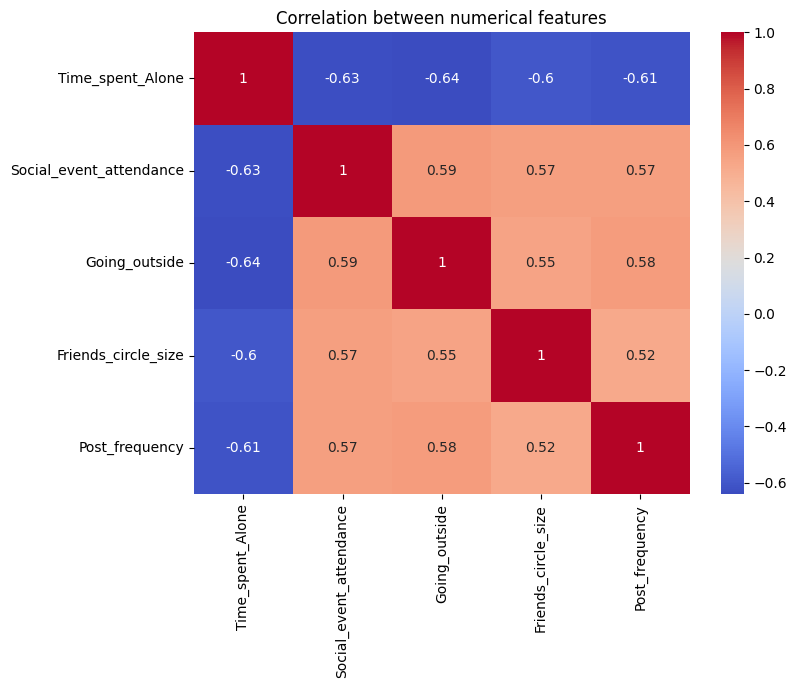

In [62]:
plt.figure(figsize=(8,6))
sns.heatmap(data[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between numerical features")
plt.show()

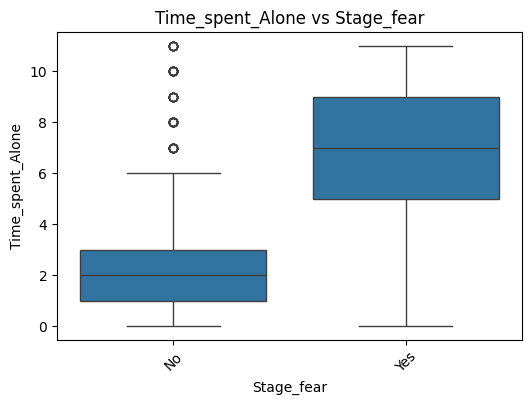

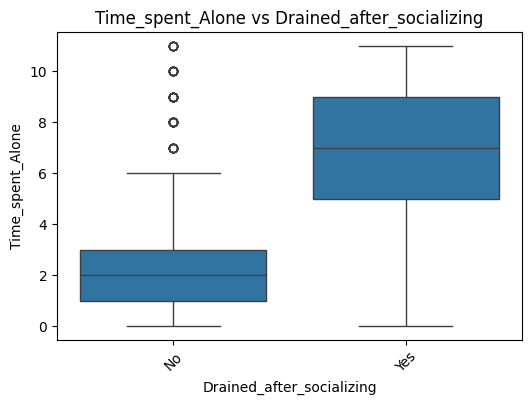

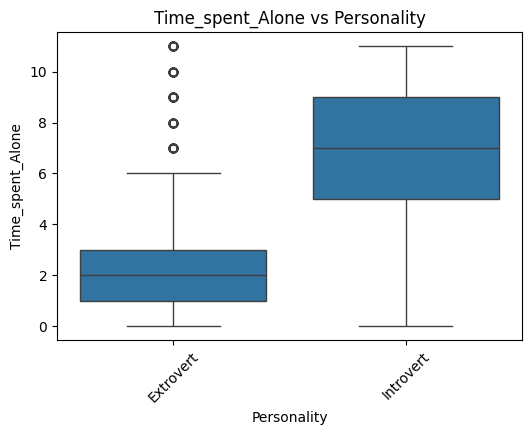

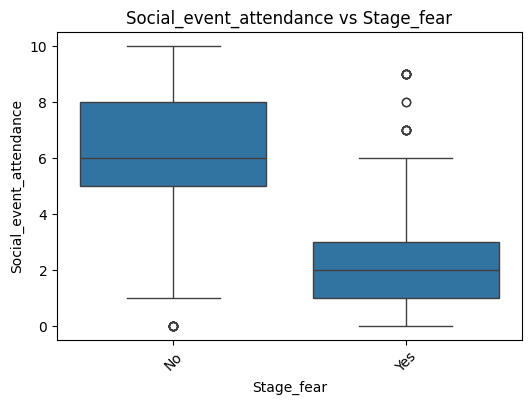

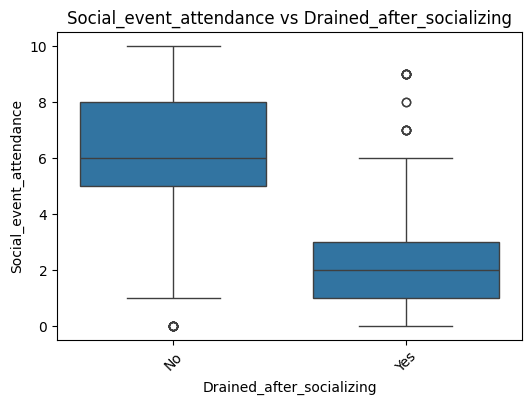

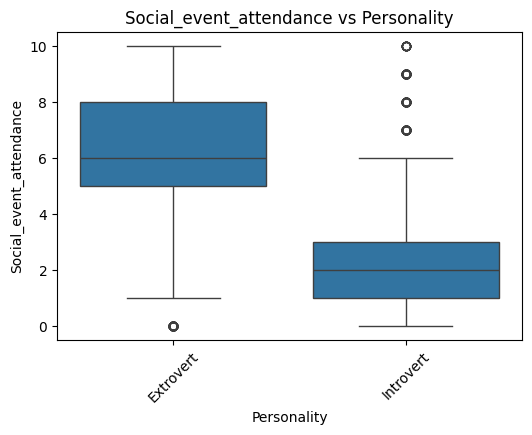

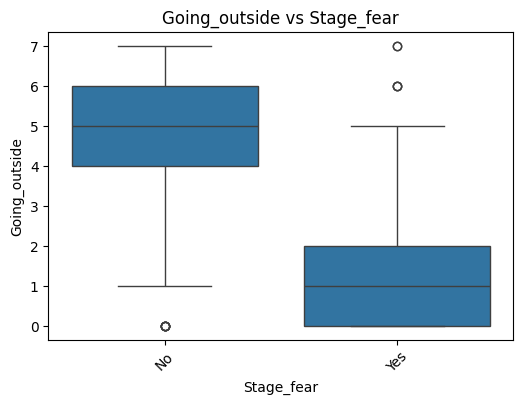

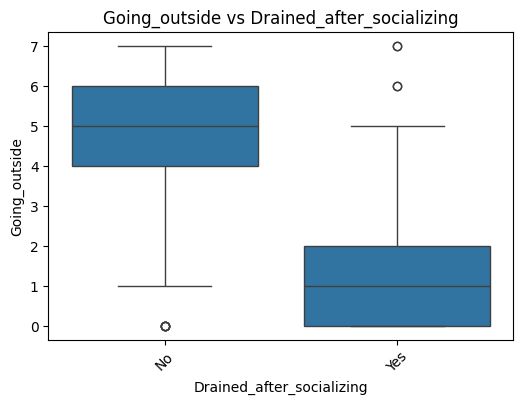

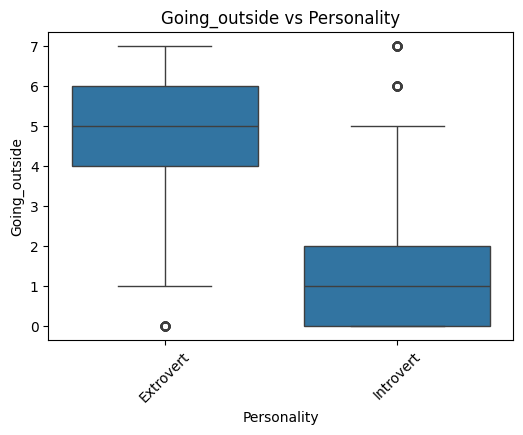

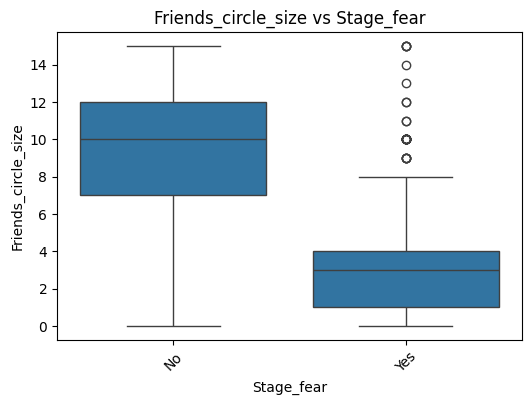

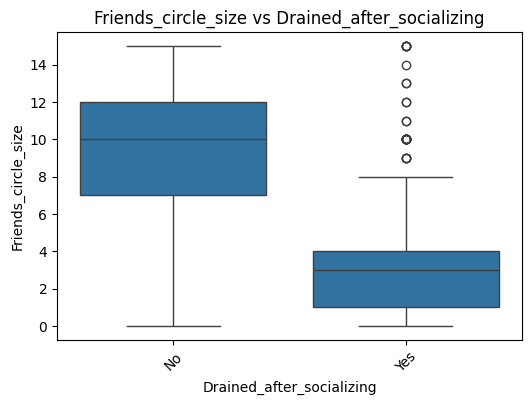

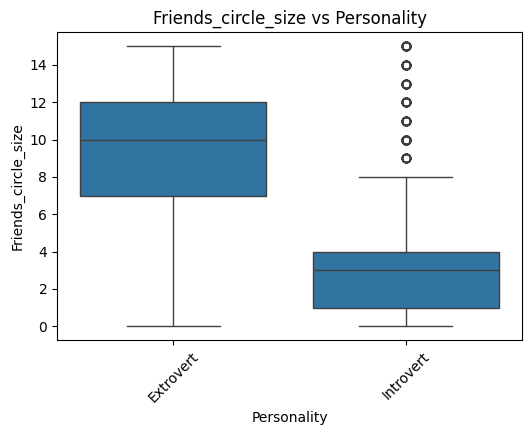

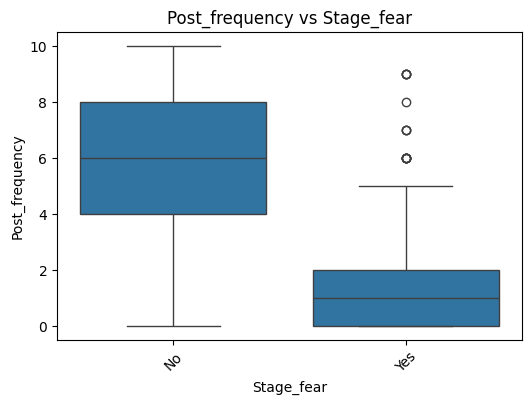

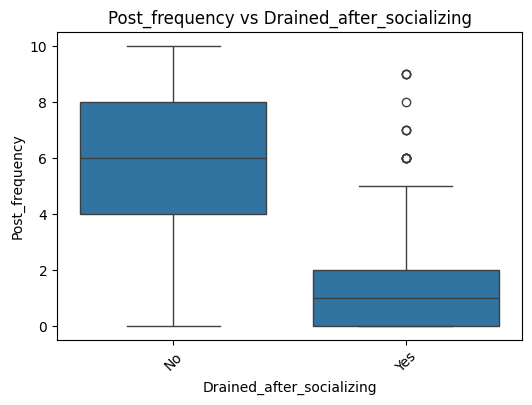

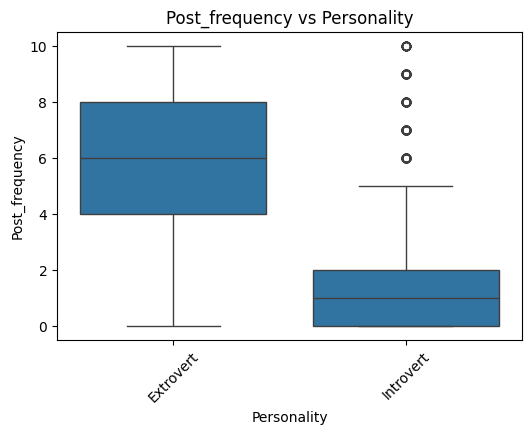

In [64]:
for col in num_cols:
    for cat_col in cat_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=data, x=cat_col, y=col)
        plt.title(f"{col} vs {cat_col}")
        plt.xticks(rotation=45)
        plt.show()

In [65]:
data.isna().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

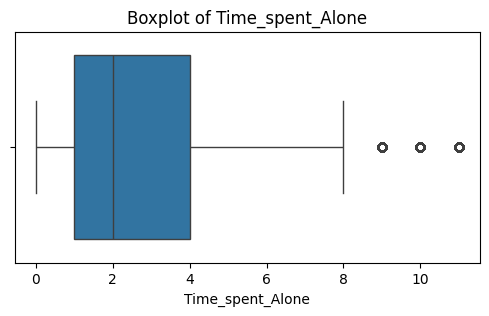

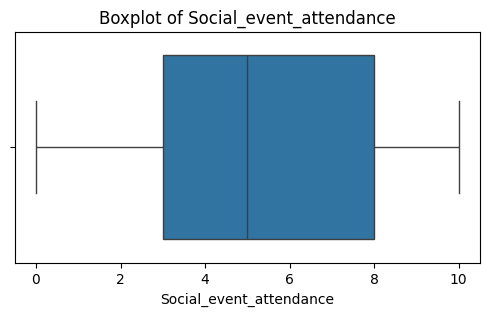

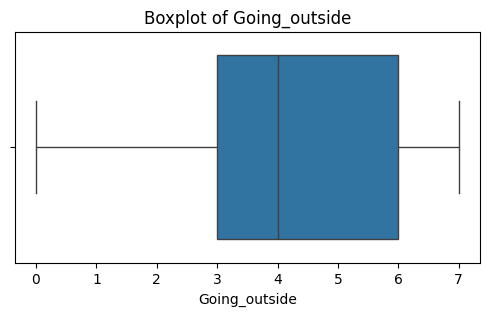

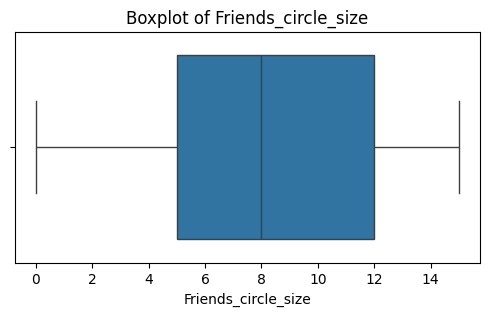

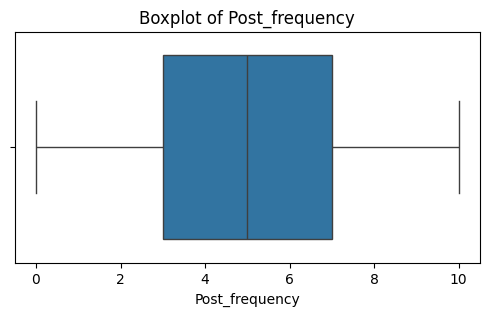

In [71]:
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [94]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

for col in num_cols:
    outliers = detect_outliers_iqr(data, col)
    print(f"{col}: {len(outliers)} outliers")

Time_spent_Alone: 1653 outliers
Social_event_attendance: 0 outliers
Going_outside: 0 outliers
Friends_circle_size: 0 outliers
Post_frequency: 0 outliers


In [ ]:
data_cleaned = data.dropna()

X = data_cleaned.select_dtypes(include=['float64', 'int64']).drop(columns=['id'])
y = LabelEncoder().fit_transform(data_cleaned['Personality'])

f_scores, p_values = f_classif(X, y)

feature_scores = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)

print("F-score (ANOVA):")
print(feature_scores)

F-score (ANOVA):
Time_spent_Alone           10510.298018
Social_event_attendance     5968.099780
Going_outside               5448.672391
Post_frequency              4935.998751
Friends_circle_size         4462.160052
dtype: float64


In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

cat_cols = data.select_dtypes(include=['object', 'category']).columns.drop('Personality')

for col in cat_cols:
    v = cramers_v(data[col], data['Personality'])
    print(f"{col}: Cramér's V = {v:.3f}")

Stage_fear: Cramér's V = 0.913
Drained_after_socializing: Cramér's V = 0.912
